# Import and EDA

In [1]:
#Dataframe
import pandas as pd
from datetime import datetime as dt
import numpy as np
import pytz

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns


#Modeling
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

C:\Users\beyza\anaconda3\envs\learn-env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\beyza\anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\beyza\anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df=pd.read_csv('Data\Supply_Chain_Shipment_Pricing_Data.csv')

In [3]:
df.head()

,id,project code,pq #,po / so #,asn/dn #,country,managed by,fulfill via,vendor inco term,shipment mode,...,unit of measure (per pack),line item quantity,line item value,pack price,unit price,manufacturing site,first line designation,weight (kilograms),freight cost (usd),line item insurance (usd)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,True,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",True,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,True,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",True,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",True,7590,45450.08,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            10324 non-null  int64  
 1   project code                  10324 non-null  object 
 2   pq #                          10324 non-null  object 
 3   po / so #                     10324 non-null  object 
 4   asn/dn #                      10324 non-null  object 
 5   country                       10324 non-null  object 
 6   managed by                    10324 non-null  object 
 7   fulfill via                   10324 non-null  object 
 8   vendor inco term              10324 non-null  object 
 9   shipment mode                 9964 non-null   object 
 10  pq first sent to client date  10324 non-null  object 
 11  po sent to vendor date        10324 non-null  object 
 12  scheduled delivery date       10324 non-null  object 
 13  d

In [5]:
df['country'].value_counts()

South Africa          1406
Nigeria               1194
Côte d'Ivoire         1083
Uganda                 779
Vietnam                688
Zambia                 683
Haiti                  655
Mozambique             631
Zimbabwe               538
Tanzania               519
Rwanda                 430
Congo, DRC             333
Guyana                 237
Ethiopia               216
South Sudan            164
Kenya                  111
Burundi                 98
Namibia                 95
Cameroon                75
Botswana                70
Ghana                   58
Dominican Republic      52
Sudan                   46
Swaziland               35
Mali                    17
Pakistan                15
Guatemala               15
Malawi                  14
Benin                   13
Libya                    8
Lebanon                  8
Angola                   7
Liberia                  6
Sierra Leone             4
Lesotho                  4
Togo                     3
Senegal                  3
A

In [6]:
df['shipment mode'].value_counts()

Air            6113
Truck          2830
Air Charter     650
Ocean           371
Name: shipment mode, dtype: int64

# Data Cleaning

### Dropping Columns

In [7]:
df.drop(columns=[
    'pq #',
    'po / so #',
    'asn/dn #', 
    'pq first sent to client date', 
    'po sent to vendor date', 
    'line item insurance (usd)', 
    'id',
    'project code',
    'managed by',
    'fulfill via',
    'vendor inco term',
    'shipment mode',
    'delivery recorded date',
    'molecule/test type',
    'brand',
    'dosage',
    'dosage form',
    'unit of measure (per pack)',
    'pack price',
    'unit price',
    'manufacturing site',
    'first line designation',
    'weight (kilograms)',
    'freight cost (usd)'], inplace=True)

## Dropping Rows

Dropping countries with less than 100 instances

In [8]:
df = df[df['country'].map(df['country'].value_counts()) >= 50]

In [9]:
df['country'].value_counts() #SANITY CHECK

South Africa          1406
Nigeria               1194
Côte d'Ivoire         1083
Uganda                 779
Vietnam                688
Zambia                 683
Haiti                  655
Mozambique             631
Zimbabwe               538
Tanzania               519
Rwanda                 430
Congo, DRC             333
Guyana                 237
Ethiopia               216
South Sudan            164
Kenya                  111
Burundi                 98
Namibia                 95
Cameroon                75
Botswana                70
Ghana                   58
Dominican Republic      52
Name: country, dtype: int64

In [10]:
df.info() #SANITY CHECK

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10115 entries, 0 to 10323
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   10115 non-null  object 
 1   scheduled delivery date   10115 non-null  object 
 2   delivered to client date  10115 non-null  object 
 3   product group             10115 non-null  object 
 4   sub classification        10115 non-null  object 
 5   vendor                    10115 non-null  object 
 6   item description          10115 non-null  object 
 7   line item quantity        10115 non-null  int64  
 8   line item value           10115 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 790.2+ KB


In [11]:
df.head()

,country,scheduled delivery date,delivered to client date,product group,sub classification,vendor,item description,line item quantity,line item value
0,Côte d'Ivoire,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...",19,551.0
1,Vietnam,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",1000,6200.0
2,Côte d'Ivoire,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests",500,40000.0
3,Vietnam,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",31920,127360.8
4,Vietnam,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",38000,121600.0


In [12]:
df['vendor'].value_counts()

SCMS from RDC                                      5334
S. BUYS WHOLESALER                                  715
Orgenics, Ltd                                       691
Aurobindo Pharma Limited                            665
ABBVIE LOGISTICS (FORMERLY ABBOTT LOGISTICS BV)     345
                                                   ... 
ABBOTT LABORATORIES (PUERTO RICO)                     1
RAININ INSTRUMENT, LLC.                               1
AUROBINDO PHARAM (SOUTH AFRICA)                       1
ACOUNS NIGERIA LTD                                    1
KAS MEDICS LIMITED                                    1
Name: vendor, Length: 71, dtype: int64

In [13]:
#Dropping vendors with less than 50 instances
df = df[df['vendor'].map(df['vendor'].value_counts()) >= 50]

In [14]:
#Checking the rows where the two date columns don't match
df['unscheduled_delivery'] = df.apply(lambda row: row['scheduled delivery date'] != row['delivered to client date'], axis=1)
df[df['unscheduled_delivery'] == True]

,country,scheduled delivery date,delivered to client date,product group,sub classification,vendor,item description,line item quantity,line item value,unscheduled_delivery
25,Haiti,13-Aug-07,21-Aug-07,HRDT,HIV test,"Orgenics, Ltd","HIV 1/2, Determine HIV Kit, without Lancets, 1...",750,53992.50,True
41,Guyana,9-Apr-08,1-Apr-08,HRDT,HIV test - Ancillary,"Orgenics, Ltd","HIV, Lancet, Safety, for HIV Test kits, 100 Pcs",240,2.40,True
51,South Africa,25-Apr-08,7-Apr-08,ARV,Pediatric,S. BUYS WHOLESALER,"Didanosine 25mg [Videx], chewable tablets, 60 ...",6,77.10,True
53,Nigeria,9-Jul-08,4-Jul-08,HRDT,HIV test - Ancillary,"Orgenics, Ltd","HIV, Lancet, Safety, for HIV Test kits, 100 Pcs",5498,54.98,True
57,South Africa,20-Aug-08,8-May-08,ARV,Adult,S. BUYS WHOLESALER,"Didanosine EC 250mg [Videx EC], delayed-releas...",100,1906.00,True
...,...,...,...,...,...,...,...,...,...,...
10319,Zimbabwe,31-Jul-15,15-Jul-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",166571,599655.60,True
10320,Côte d'Ivoire,31-Jul-15,6-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",21072,137389.44,True
10321,Zambia,31-Aug-15,25-Aug-15,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,514526,5140114.74,True
10322,Zimbabwe,9-Sep-15,4-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",17465,113871.80,True


In [15]:
#Flagging vendors with the most delayed deliveries 
df[df['unscheduled_delivery'] == True]['vendor'].value_counts()

SCMS from RDC                                                        3298
S. BUYS WHOLESALER                                                    251
Orgenics, Ltd                                                         161
Aurobindo Pharma Limited                                              116
CIPLA LIMITED                                                          29
CHEMBIO DIAGNOSTIC SYSTEMS, INC.                                       13
HETERO LABS LIMITED                                                    11
Standard Diagnostics, Inc.                                             10
SHANGHAI KEHUA BIOENGINEERING CO.,LTD.  (KHB)                          10
MYLAN LABORATORIES LTD (FORMERLY MATRIX LABORATORIES)                   7
ABBVIE LOGISTICS (FORMERLY ABBOTT LOGISTICS BV)                         6
STRIDES ARCOLAB LIMITED                                                 5
Trinity Biotech, Plc                                                    3
MERCK SHARP & DOHME IDEA GMBH (FORMALL

# TimeSeries

In [16]:
df['delivered to client date'] = df['delivered to client date'].astype(str)

In [17]:
df['delivered to client date'] = pd.to_datetime(df['delivered to client date'], infer_datetime_format=True)
df.set_index('delivered to client date', inplace=True)

In [18]:
df.head()#SANITY CHECK

,country,scheduled delivery date,product group,sub classification,vendor,item description,line item quantity,line item value,unscheduled_delivery
delivered to client date,,,,,,,,,
2006-11-14,Vietnam,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",1000,6200.00,False
2006-08-11,Vietnam,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",38000,121600.00,False
2006-09-28,Nigeria,28-Sep-06,ARV,Pediatric,Aurobindo Pharma Limited,"Zidovudine 10mg/ml, oral solution, Bottle, 240 ml",416,2225.60,False
2007-01-08,Zambia,8-Jan-07,ARV,Pediatric,MERCK SHARP & DOHME IDEA GMBH (FORMALLY MERCK ...,"Efavirenz 200mg [Stocrin/Sustiva], capsule, 90...",135,4374.00,False
2006-11-24,Tanzania,24-Nov-06,ARV,Adult,Aurobindo Pharma Limited,"Nevirapine 200mg, tablets, 60 Tabs",16667,60834.55,False


In [19]:
df.isnull().sum()

country                    0
scheduled delivery date    0
product group              0
sub classification         0
vendor                     0
item description           0
line item quantity         0
line item value            0
unscheduled_delivery       0
dtype: int64

### Picking a column to use with date

In [20]:
df['sub classification'].value_counts()

Adult                   6348
Pediatric               1861
HIV test                1318
HIV test - Ancillary     129
Malaria                    1
Name: sub classification, dtype: int64

In [21]:
df['item description'].value_counts()

Efavirenz 600mg, tablets, 30 Tabs                                                  735
Nevirapine 200mg, tablets, 60 Tabs                                                 609
Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs                                  594
Lamivudine/Nevirapine/Zidovudine 150/200/300mg, tablets, 60 Tabs                   573
HIV 1/2, Determine Complete HIV Kit, 100 Tests                                     497
                                                                                  ... 
Lopinavir/Ritonavir 200/50mg, [DON] tablets, 120 Tabs                                1
Lamivudine/Zidovudine+Abacavir 150/300+300mg, tablets, co-blister, 60+60 Tabs        1
Nevirapine 50mg, dispersible tablets, 60 Tabs                                        1
Lamivudine/Nevirapine/Zidovudine 30/50/60mg, [DON] dispersible tablets, 60 Tabs      1
Lamivudine 300mg, tablets, 30 Tabs                                                   1
Name: item description, Length: 145, dtype:

In [22]:
df['product group'].value_counts()

ARV     8209
HRDT    1447
MRDT       1
Name: product group, dtype: int64

In [23]:
df['scheduled delivery date']= pd.to_datetime(df['scheduled delivery date'])

<AxesSubplot:xlabel='scheduled delivery date', ylabel='line item quantity'>

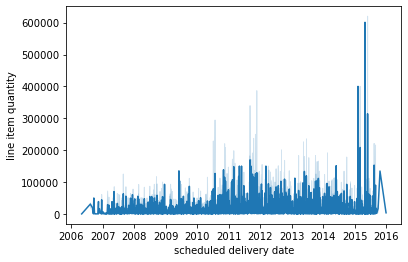

In [24]:
sns.lineplot(x="scheduled delivery date", y="line item quantity", data=df)

## Visualizations for 2015

In [25]:
df_year = df[df["scheduled delivery date"] >= "2015-01-01"]

<AxesSubplot:xlabel='scheduled delivery date', ylabel='line item quantity'>

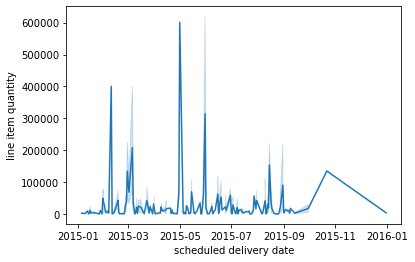

In [26]:
sns.lineplot(x="scheduled delivery date", y="line item quantity", data=df_year)

Above graph goes down nearing 2016 and that's where the supplying ends. It might be necessary to drop the second half of 2015 out of the model to avoid skewing the model. 

<AxesSubplot:xlabel='sub classification', ylabel='line item quantity'>

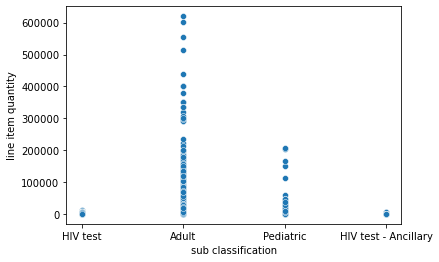

In [27]:
sns.scatterplot(data=df_year, x="sub classification", y="line item quantity")

## NEW TimeSeries Dataframe

In [28]:
# create time series data
ts_df = df.pivot_table(index='delivered to client date', columns='product group', values='line item quantity')


# convert to datetime
ts_df.index = pd.to_datetime(ts_df.index, format="%d-%m-%Y")
ts_df.index.name = "delivery date"
ts_df.index = ts_df.index.strftime("%m-%Y")

# remove timezone information--fixig plot error
ts_df.index = pd.to_datetime(ts_df.index).tz_localize(None)


ts_df = ts_df.resample("M").last()


# handling missing values
ts_df=ts_df.fillna(0)


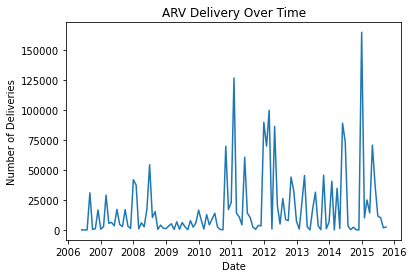

In [29]:
plt.plot(ts_df.index, ts_df['ARV'])

# titles and labels
plt.title('ARV Delivery Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Deliveries')


plt.show()

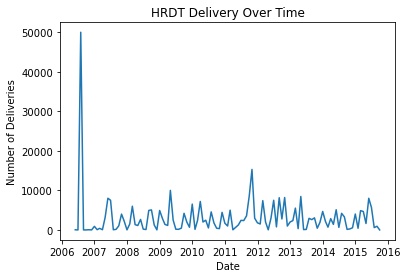

In [30]:
plt.plot(ts_df.index, ts_df['HRDT'])

# titles and labels
plt.title('HRDT Delivery Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Deliveries')


plt.show()

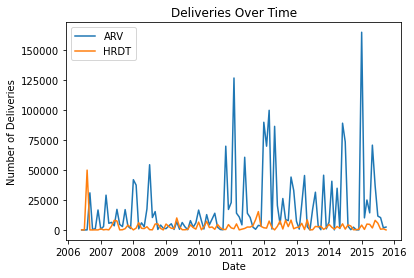

In [31]:
# the data
plt.plot(ts_df.index, ts_df['ARV'], label='ARV')
plt.plot(ts_df.index, ts_df['HRDT'], label='HRDT')

# titles and labels
plt.title('Deliveries Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Deliveries')

plt.legend()
plt.show()

In [32]:
ts_df.head()

product group,ARV,HRDT,MRDT
delivery date,,,
2006-05-31,0.0,31.0,0.0
2006-06-30,0.0,0.0,0.0
2006-07-31,0.0,50000.0,0.0
2006-08-31,31000.0,0.0,0.0
2006-09-30,433.5,0.0,0.0


# Stationarity Test

In [33]:
dftest = adfuller(ts_df['ARV'])
print('p-value:', dftest[1])
alpha=0.05

if dftest[1] < alpha:
    print("The data is stationary")
else:
    print("The data is non-stationary")
 

p-value: 1.4101439569394792e-16
The data is stationary


In [34]:
dftest = adfuller(ts_df['HRDT'])
print('p-value:', dftest[1])
alpha=0.05

if dftest[1] < alpha:
    print("The data is stationary")
else:
    print("The data is non-stationary")


p-value: 0.1997321559460396
The data is non-stationary


# HRDT STATIONARY

### Log Difference

In [35]:
#to avoid getting -inf
ts_df = ts_df + 1

In [36]:
ts_df['HRDT'] = np.log(ts_df['HRDT'])
ts_df['HRDT'] = ts_df['HRDT'].diff()
ts_df = ts_df.drop(ts_df.index[0])

In [37]:
ts_df['HRDT'].isnull().sum()

0

In [38]:
ts_df['HRDT'].fillna(0)

delivery date
2006-06-30    -3.465736
2006-07-31    10.819798
2006-08-31   -10.819798
2006-09-30     0.000000
2006-10-31     3.828641
                ...    
2015-05-31     1.596523
2015-06-30    -0.342263
2015-07-31    -2.271739
2015-08-31     0.456474
2015-09-30    -6.829794
Freq: M, Name: HRDT, Length: 112, dtype: float64

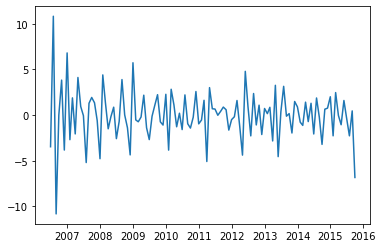

In [39]:
plt.plot(ts_df['HRDT'])

# First Simple Model

In [40]:
# Train-test split
train_data = ts_df.loc[:'09-2014']
test_data = ts_df.loc['10-2014':]

# ARIMA model
model = sm.tsa.ARIMA(train_data['ARV'], order=(1, 1, 1), dates=train_data.index, freq='M')
results = model.fit()

arv_pred = results.predict(start='11-2014', end='10-2015')

#error
mae = pd.Series.abs(arv_pred - test_data['ARV']).mean()
print('Mean Absolute Error:', mae)

Mean Absolute Error: 28586.05681335224


In [41]:
# Train-test split
train_data = ts_df.loc[:'09-2014']
test_data = ts_df.loc['10-2014':]


# ARIMA model
model = sm.tsa.ARIMA(train_data['HRDT'], order=(1, 1, 1), dates=train_data.index, freq='M')
results = model.fit()

hrdt_pred = results.predict(start='11-2014', end='10-2015')

# error
mae = pd.Series.abs(hrdt_pred - test_data['HRDT']).mean()
print('Mean Absolute Error:', mae)

Mean Absolute Error: 1.8389643897674766


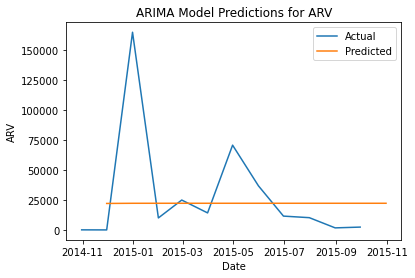

In [42]:
plt.plot(test_data.index, test_data['ARV'], label='Actual')
plt.plot(arv_pred.index, arv_pred, label='Predicted')

plt.title('ARIMA Model Predictions for ARV')
plt.xlabel('Date')
plt.ylabel('ARV')
plt.legend()

plt.show()

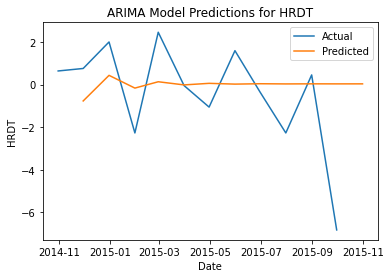

In [43]:
plt.plot(test_data.index, test_data['HRDT'], label='Actual')
plt.plot(hrdt_pred.index, hrdt_pred, label='Predicted')

plt.title('ARIMA Model Predictions for HRDT')
plt.xlabel('Date')
plt.ylabel('HRDT')
plt.legend()

plt.show()

# SARIMA

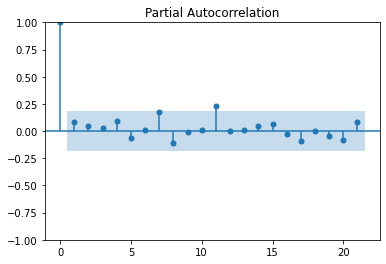

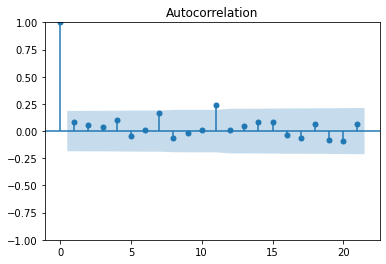

In [44]:
plot_pacf(ts_df['ARV'], method='ywm');
plot_acf(ts_df['ARV']);

In [45]:
# Train-test split
train_data = ts_df.loc[:'09-2014']
test_data = ts_df.loc['10-2014':]

# SARIMA model
model = sm.tsa.statespace.SARIMAX(train_data['ARV'], order=(0,0,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Predictions
arv_pred = results.predict(start='11-2014', end='9-2015')

# Error
mae = pd.Series.abs(arv_pred - test_data['ARV']).mean()
print('Mean Absolute Error:', mae)


Mean Absolute Error: 24226.527404192773


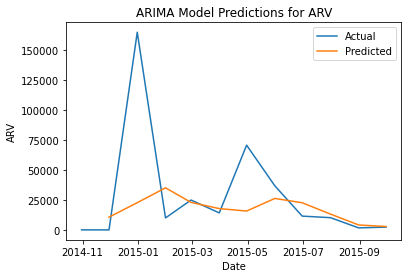

In [46]:
plt.plot(test_data.index, test_data['ARV'], label='Actual')
plt.plot(arv_pred.index, arv_pred, label='Predicted')

plt.title('ARIMA Model Predictions for ARV')
plt.xlabel('Date')
plt.ylabel('ARV')
plt.legend()

plt.show()

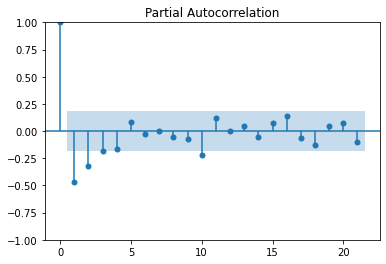

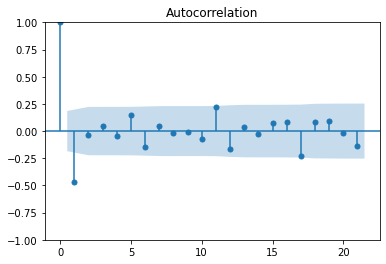

In [47]:
plot_pacf(ts_df['HRDT'], method='ywm');
plot_acf(ts_df['HRDT']);

In [48]:
# Train-test split
train_data = ts_df.loc[:'09-2014']
test_data = ts_df.loc['10-2014':]

# SARIMA model
model = sm.tsa.statespace.SARIMAX(train_data['ARV'], order=(2,1,1), seasonal_order=(0,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Predictions
hrdt_pred = results.predict(start='11-2014', end='9-2015')

# Error
mae = pd.Series.abs(hrdt_pred - test_data['HRDT']).mean()
print('Mean Absolute Error:', mae)


Mean Absolute Error: 26845.908012867512


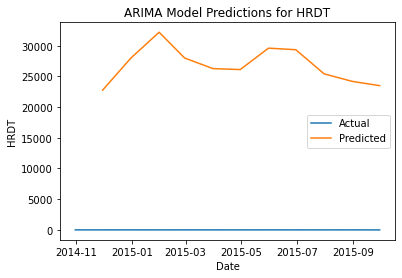

In [49]:
plt.plot(test_data.index, test_data['HRDT'], label='Actual')
plt.plot(hrdt_pred.index, hrdt_pred, label='Predicted')

plt.title('ARIMA Model Predictions for HRDT')
plt.xlabel('Date')
plt.ylabel('HRDT')
plt.legend()

plt.show()

# GridSearch for SARIMA parameters